<a href="https://colab.research.google.com/github/masabhuq/breast-cancer-prediction/blob/main/Breast_Cancer_Prediction_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
from torchsummary import summary

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocessing

In [186]:
from sklearn import datasets, metrics

In [187]:
cancer = datasets.load_breast_cancer()

In [188]:
cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [189]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [190]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [191]:
X = pd.DataFrame(data = cancer['data'], columns=cancer.feature_names)
y = pd.DataFrame(data = cancer['target'], columns = ['label'])
y.head()

,label
0,0
1,0
2,0
3,0
4,0


## Splitting the Dataset

### Checking the skew of the dataset

In [194]:
y.value_counts(normalize = True)

label
1        0.627417
0        0.372583
dtype: float64

The dataset seems to be a little skewed. But the skew is not too much. So we can work normally with this one.

### Creating train test split

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Scaling the features

In [196]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

In [197]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [198]:
X_train.shape, X_test.shape

(torch.Size([455, 30, 1]), torch.Size([114, 30, 1]))

In [199]:
y_train.shape, y_test.shape

(torch.Size([455, 1]), torch.Size([114, 1]))

In [200]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [201]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Creating the model

In [211]:
# Create a convolutional neural network
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.cnn1 = nn.Sequential(
        nn.Conv1d(in_channels=30,
                  out_channels=32,
                  kernel_size=1),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.cnn2 = nn.Sequential(
        nn.Conv1d(in_channels=32, # 32 feature maps from previous layer
                  out_channels=64,
                  kernel_size=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.4)
    )
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64, 32) # Need explanation
    self.fc2 = nn.Linear(32,1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.cnn1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.cnn2(x) 
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.flatten(x)
    # print(f"Output shape of classifier: {x.shape}")
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

In [212]:
model = ConvNet()

In [69]:
model

ConvNet(
  (cnn1): Sequential(
    (0): Conv1d(30, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

# Training the Model

In [213]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [214]:
num_epochs = 250
losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    
    # iterate over the batches in the dataloader
    for batch_inputs, batch_labels in train_loader:
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        batch_outputs = model(batch_inputs)

        # calculate the loss
        loss = criterion(batch_outputs, batch_labels.float())
        
        # backward pass
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # calculate accuracy
        _, preds = torch.max(batch_outputs, 1)
        running_loss += loss.item() * batch_inputs.size(0)
        running_corrects += torch.sum(preds == batch_labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    epoch_acc = running_corrects.double() / len(train_loader.dataset) * 100

    if(epoch % 25 == 1):
      print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 2/250 - Loss: 0.6530
Epoch 27/250 - Loss: 0.6128
Epoch 52/250 - Loss: 0.5674
Epoch 77/250 - Loss: 0.5254
Epoch 102/250 - Loss: 0.5075
Epoch 127/250 - Loss: 0.4929
Epoch 152/250 - Loss: 0.4880
Epoch 177/250 - Loss: 0.4848
Epoch 202/250 - Loss: 0.4781
Epoch 227/250 - Loss: 0.4755


# Number of Epochs VS Binary Cross Entropy Loss
Initially I tested for Number of Epochs = 500. 
<br/> It was observed that the graph plateaus at 250 epochs. So that's the ideal number of epochs

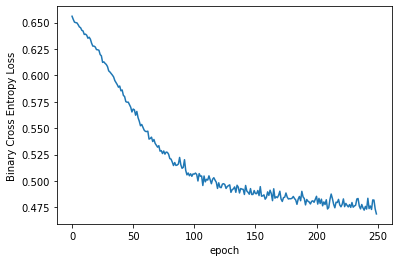

In [233]:
plt.plot(range(num_epochs), losses)
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('epoch');

# Evaluation

## Preparation for Evaluation

In [219]:
test_loader_no_batch = DataLoader(test_data)

In [221]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  

predictions_list = []
targets_list = []
correct = 0
total = 0
with torch.no_grad():  
    for data in test_loader_no_batch:
        inputs, targets = data
        targets_list.append(targets)
        outputs = model(inputs)
        predictions_list.append((outputs > 0.5).float())

In [226]:
predictions_list = [i.item() for i in predictions_list]
targets_list = [i.item() for i in targets_list]

In [218]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score, roc_auc_score, recall_score

## Evaluation
Using metrics for classification and confusion matrix.

In [231]:
print(f"roc_auc_score : {roc_auc_score(targets_list, predictions_list)}")
print(f"accuracy_score : {accuracy_score(targets_list, predictions_list)}")
print(f"recall_score : {recall_score(targets_list, predictions_list)}")
print(f"f1_score : {f1_score(targets_list, predictions_list)}")

roc_auc_score : 0.9897959183673469
accuracy_score : 0.9912280701754386
recall_score : 1.0
f1_score : 0.9923664122137404


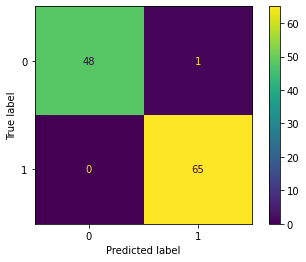

In [232]:
ConfusionMatrixDisplay.from_predictions(targets_list, predictions_list)

# Saving the Model

In [217]:
torch.save(model.state_dict(), "ConvNet_Breast_Cancer_Prediction.pt")